In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.transform.radon_transform import _get_fourier_filter
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom

def interpolate(data, r, theta, x, y):
    """
    Bi-linear interpolation from radial grid (ks,theta) to cartesian grid (kx,ky), 
    related via kx = ks*cos(theta), ky = -ks*sin(theta).

    The radial coordinates are assumed to be have negative radii and theta in [0,pi). Note: This is equivalent to only allowing positive radii and letting theta be in [0,2pi).

    Input: 
        f_hat     - 2d array of size (ns,ntheta) containing values on the radial grid
        theta, ks - 1d arrays of size ns and nt containing the polar gridpoints
        kx, ky    - 1d arrays of size nx and ny containing the cartesian gridpoints

    Output:
        u_hat     - 2d array of size (nx,nt) containing the interpolated values
    """
    
    nr, nt = len(r), len(theta)
    dr = r[1] - r[0] if nr > 1 else 1
    dt = theta[1] - theta[0] if nt > 1 else 2 * np.pi
    nx, ny = len(x), len(y)
    
    result = np.zeros((nx, ny), dtype=data.dtype)

    def ctop(x, y):
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x) % (2 * np.pi)
        return r, theta

    # Function to find the lower-left grid point in the polar grid
    def find_grid_indices(r_ij, theta_ij):
        k = int((r_ij - r[0]) // dr)
        l = int((theta_ij - theta[0]) // dt)
        return k, l

    # Loop over the x,y grid
    for i in range(nx):
        for j in range(ny):
            # convert (x,y) to polar using function ctop
            r_ij, theta_ij = ctop(x[i], y[j])

            k, l = find_grid_indices(r_ij, theta_ij)

            # Check if the point (i, j) is within the bounds for interpolation
            if 0 <= k < nr - 1 and 0 <= l < nt - 1:
                # Interpolation weights, as per the bi-linear interpolation formula
                A = (r[k+1] - r_ij) * (theta[l+1] - theta_ij) / (dr * dt)
                B = (r_ij - r[k]) * (theta[l+1] - theta_ij) / (dr * dt)
                C = (r[k+1] - r_ij) * (theta_ij - theta[l]) / (dr * dt)
                D = (r_ij - r[k]) * (theta_ij - theta[l]) / (dr * dt)
                
                # Apply the the formula using the constructed weights
                result[i, j] = (A * data[k, l] + 
                                B * data[k + 1, l] + 
                                C * data[k, l + 1] + 
                                D * data[k + 1, l + 1])

    return result

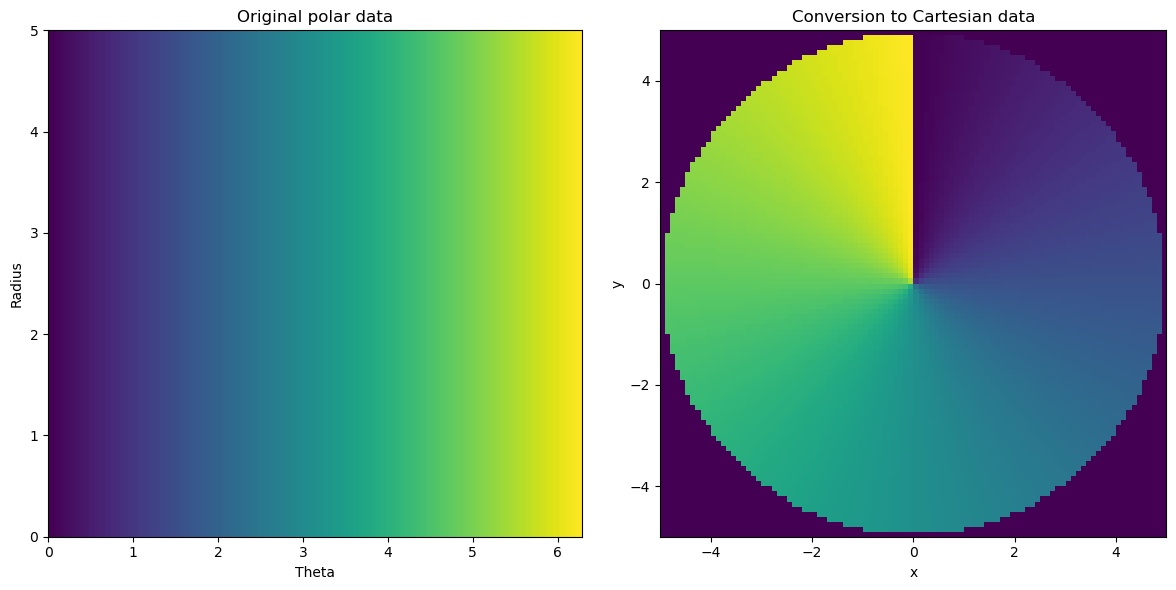

In [6]:
def f(r, theta):
    return theta

# define the polar grid (r, theta)
nr = 100
ntheta = 180
r = np.linspace(0, 5, nr)
theta = np.linspace(0, 2 * np.pi, ntheta)

# create the polar data using the test function
R, Theta = np.meshgrid(r, theta, indexing='ij')
data = f(R, Theta)

# define the cgrid (x, y) centered at the origin
nx = ny = 100
extent = 5
x = np.linspace(-extent, extent, nx)
y = np.linspace(-extent, extent, ny)

interpolated_data = interpolate(data, r, theta, x, y)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# original data in polar coordinates
ax[0].imshow(data, extent=[0, 2 * np.pi, 0, 5], aspect='auto', origin='lower')
ax[0].set_title('Original polar data')
ax[0].set_xlabel('Theta')
ax[0].set_ylabel('Radius')

# converted data in (x,y) coordinates
# set extent so that the grid is centered at the origin
im = ax[1].imshow(interpolated_data, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[1].set_title('Conversion to Cartesian data')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.tight_layout()
plt.savefig("/Users/Senne/Downloads/testinterpolate.png")

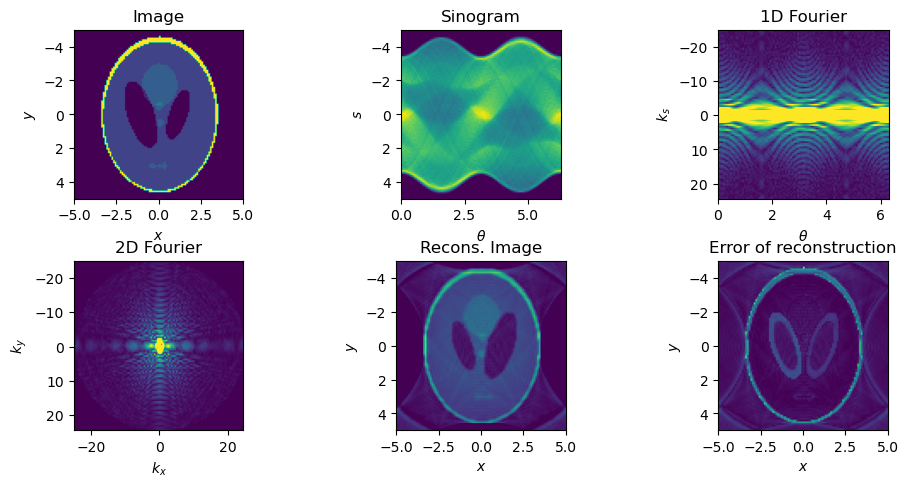

In [89]:
nx = 100
na = 100
theta = np.linspace(0., 360., na)
sigma = 0

u = shepp_logan_phantom()[::4, ::4]

# noisy sinogram
f = radon(u, theta=theta)
f_noisy = f + sigma * np.random.randn(nx,na)

# 1D Fourier
f_hat = fftshift(fft(ifftshift(f,axes=0), axis = 0), axes = 0)
ks = fftshift(fftfreq(nx, 2/nx))

# 2D frequency grid
kx = fftshift(fftfreq(nx, 2/nx))
ky = fftshift(fftfreq(nx, 2/nx))

# interpolate; the interpolate function only works with positive radii, so we let the angle run in [0,2pi) instead of [0.pi).
u_hat = interpolate(f_hat, -ks, 2*np.pi*theta / 360, kx, ky)

u_rec = np.real(fftshift(ifft2(ifftshift(u_hat))))

# compare error with original image graphically
error = abs(u-u_rec.T)

fig, ax = plt.subplots(2,3)

ax[0,0].imshow(u,vmax=1,extent=(x[0],x[-1],y[-1],y[0]))
ax[0,0].set_aspect(1)
ax[0,0].set_title('Image')
ax[0,0].set_xlabel(r'$x$')
ax[0,0].set_ylabel(r'$y$')

ax[0,1].imshow(f,extent=(2*np.pi*theta[0]/360,2*np.pi*theta[-1]/360,x[-1],x[0]))
ax[0,1].set_aspect(2/3)
ax[0,1].set_title('Sinogram')
ax[0,1].set_xlabel(r'$\theta$')
ax[0,1].set_ylabel(r'$s$')

ax[0,2].imshow(np.abs(f_hat),vmax=1e2,extent=(2*np.pi*theta[0]/360,2*np.pi*theta[-1]/360,ks[-1],ks[0]))
ax[0,2].set_aspect(4*np.pi/nx)
ax[0,2].set_title('1D Fourier')
ax[0,2].set_xlabel(r'$\theta$')
ax[0,2].set_ylabel(r'$k_s$')

ax[1,0].imshow(np.abs(u_hat),vmax=1e2,extent=(kx[0],kx[-1],ky[-1],ky[0]))
ax[1,0].set_aspect(1)
ax[1,0].set_title('2D Fourier')
ax[1,0].set_xlabel(r'$k_x$')
ax[1,0].set_ylabel(r'$k_y$')

ax[1,1].imshow(u_rec.T,vmax=1, vmin=0,extent=(x[0],x[-1],y[-1],y[0]))
ax[1,1].set_aspect(1)
ax[1,1].set_title('Recons. Image')
ax[1,1].set_xlabel(r'$x$')
ax[1,1].set_ylabel(r'$y$')

ax[1,2].imshow(error,vmax=1,extent=(x[0],x[-1],y[-1],y[0]))
ax[1,2].set_aspect(1)
ax[1,2].set_title('Error of reconstruction')
ax[1,2].set_xlabel(r'$x$')
ax[1,2].set_ylabel(r'$y$')

fig.tight_layout()
fig.set_figwidth(10)
plt.savefig("/Users/Senne/Downloads/fourierrec.png")

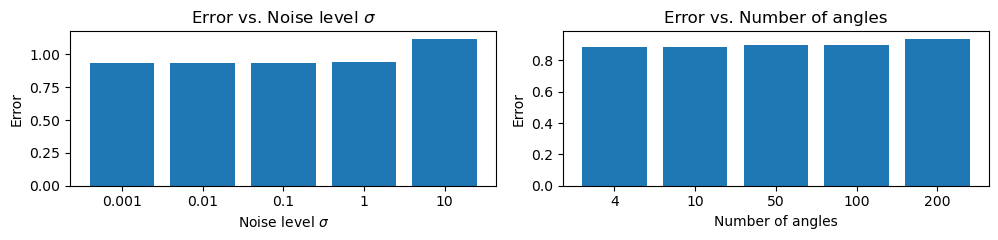

In [111]:
def fourier_reconstruction(f, nx):
    # 1D Fourier
    f_hat = fftshift(fft(ifftshift(f,axes=0), axis = 0), axes = 0)
    ks = fftshift(fftfreq(nx, 2/nx))
    
    # 2D frequency grid
    kx = fftshift(fftfreq(nx, 2/nx))
    ky = fftshift(fftfreq(nx, 2/nx))
    
    # interpolate; the interpolate function only works with positive radii, so we let the angle run in [0,2pi) instead of [0.pi).
    u_hat = interpolate(f_hat, -ks, 2*np.pi*theta / 360, kx, ky)
    
    u_rec = np.real(fftshift(ifft2(ifftshift(u_hat))))
    
    return u_rec


nx = 400
na = 400
theta = np.linspace(0., 180., na)
sigmas = [.001, .01, .1, 1, 10]
nas = [4, 10, 50, 100, 200]

u = shepp_logan_phantom()
f = radon(u, theta=theta)

errors_sigma = {}
for sigma in sigmas:
    f_noisy = f + sigma * np.random.randn(nx, na)
    
    # use fourier reconstruction and calculate error
    u_fr = fourier_reconstruction(f_noisy, nx)
    error_fr = np.linalg.norm(u - u_fr) / np.linalg.norm(u)
    errors_sigma[str(sigma)] = error_fr

errors_na = {}
for na in nas:
    theta = np.linspace(0., 180., na)
    f = radon(u, theta=theta)
    
    # use fourier reconstruction and calculate error
    u_fr = fourier_reconstruction(f, nx)
    error_fr = np.linalg.norm(u - u_fr) / np.linalg.norm(u)
    errors_na[str(na)] = error_fr

fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

ax[0].bar(errors_sigma.keys(), errors_sigma.values())
ax[0].set_xlabel("Noise level $\sigma$")
ax[0].set_ylabel("Error")
ax[0].set_title("Error vs. Noise level $\sigma$")

ax[1].bar(errors_na.keys(), errors_na.values())
ax[1].set_xlabel("Number of angles")
ax[1].set_ylabel("Error")
ax[1].set_title("Error vs. Number of angles")

fig.tight_layout()
plt.savefig("/Users/Senne/Downloads/errorfourier.png")